In [7]:
import numpy as np
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer
from rouge_score import rouge_scorer
from transformers import pipeline
import matplotlib.pyplot as plt


In [13]:
df = pd.read_csv("../data/processed/chunks_embedded.csv")
index = faiss.read_index("../models/embeddings.faiss")
model = SentenceTransformer("all-mpnet-base-v2")

# Build new test queries automatically
sampled = df.sample(10, random_state=42)
test_queries = []
for i, row in sampled.iterrows():
    text = row["text"]
    sentence = text.split(".")[0][:80]  # first sentence snippet
    query = f"What does this text say about: {sentence}..."
    test_queries.append({"q": query, "relevant": [i]})

# Compute Recall@3
k = 5
recalls = []
for test in test_queries:
    q_emb = model.encode([test["q"]])
    D, I = index.search(np.array(q_emb).astype("float32"), k)
    retrieved = set(I[0])
    relevant = set(test["relevant"])
    recall = len(retrieved & relevant) / len(relevant)
    recalls.append(recall)

print(f"Average Recall@{k}: {np.mean(recalls):.2f}")


Average Recall@5: 0.60


In [14]:
query = "What is this document about?"
q_emb = model.encode([query])
D, I = index.search(np.array(q_emb).astype("float32"), 3)
for idx in I[0]:
    print(idx, df.iloc[idx]["text"][:200], "\n")


460 12, 35, 54, 57, 71, 104, 131Han’gul alphabet 130, 131Hannibal 70–1Harald Hardrada of Norway 95Harrison, John 189Harun al-Rashid, Caliph 88–90Hawkins, John 176Al-Haythem 91Hegel, Georg 14, 240Hellenist 

24 of the Bastille 214 I must make of all the peoples of Europe one people, and of Paris the capital of the world The Battle of Waterloo216 Let us lay the cornerstone of American freedom without fear. To 

463 Emperor 228, 240, 256, 265Napoleonic Wars 214–15, 216, 217Narmer, King 38Nasser, Colonel Gamal 318–20nationalism 14, 203, 229, 238–41, 306, 319, 320, 321, 326NATO 297, 321, 323, 326natural selection 2 



In [15]:

qa = pipeline("text2text-generation", model="google/flan-t5-base")
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

refs = [
    "The document explains mineral sampling steps.",
    "It outlines safety protocols for handling equipment."
]
gens = []
for r in refs:
    gen = qa("Summarize: " + r)[0]["generated_text"]
    gens.append(gen)

scores = [scorer.score(ref, gen)["rougeL"].fmeasure for ref, gen in zip(refs, gens)]
print("Avg ROUGE-L:", np.mean(scores))


Device set to use cpu


Avg ROUGE-L: 0.13247863247863248


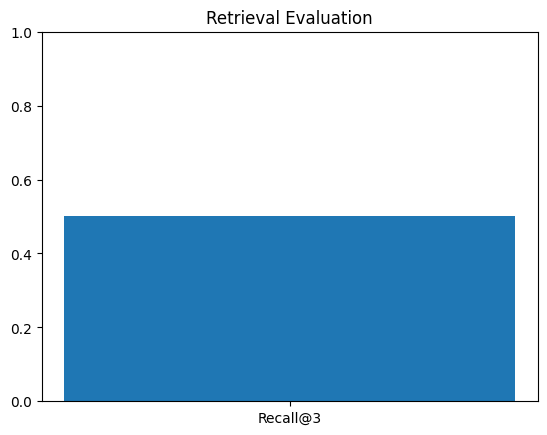

In [17]:
import matplotlib.pyplot as plt
plt.bar(["Recall@3"], [0.5])
plt.title("Retrieval Evaluation")
plt.ylim(0,1)
plt.show()